In [12]:
require('tidyverse')

Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  1.4.2     ✔ purrr   0.2.4
✔ tidyr   0.8.1     ✔ dplyr   0.7.4
✔ readr   1.1.1     ✔ stringr 1.3.0
✔ tibble  1.4.2     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand()  masks Matrix::expand()
✖ tidyr::extract() masks rstan::extract()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ dplyr::select()  masks MASS::select()


In [8]:
# goal - test out code to reduce number to run

load("../data/biomarker/m4/dat_full/dat_Testosterone.RData")

tmp <- dat$dat$B/dat$dat$SE

# 2*pnorm(-abs(z))

# Get rid of if BOTH pvalues are > 10^-5
tmp2 <- apply(tmp, c(1,2), function(z) 2*pnorm(-abs(z)))
tmp2 <- data.frame(tmp2)
colnames(tmp2) <- c("F", "M")


In [14]:
head(tmp2)
keep.rows <- (tmp2$F < (10**(-10)) | tmp2$M < (10**(-10)) )
table(keep.rows)

F,M
3.009618e-07,2.212249e-01
0.000000e+00,0.000000e+00
0.000000e+00,0.000000e+00
0.000000e+00,2.961341e-18
6.068810e-51,1.067888e-10
7.433056e-02,0.000000e+00


keep.rows
 FALSE   TRUE 
  7377 321317 

In [13]:
dat2 <- dat
dat2$chr <- dat$chr[keep.rows]
dat2$snp <- dat$snp[keep.rows]

dat2$dat$B <- dat$dat$B[keep.rows,]
dat2$dat$SE <- dat$dat$SE[keep.rows,]
dat2$dat$N <- nrow(dat2$dat$B)
dat2$dat$N

[1] 322686

In [ ]:
# this doesn't make sense - there should be
# I think the pval calc is WRONG

In [15]:
# load the data ANOTHER WAY

source('../mixture_model_scripts/model_utils.R')
list.prefixes <- c("zerosex", "onesex")
trait <- "Testosterone"
chrs <- c(1:22)
    # for each trait
    list.ds <- lapply(list.prefixes, function(prefix) {
        all.dat <- do.call(rbind, lapply(chrs, function(chr) { getFile(prefix, chr, trait)}));
        colnames(all.dat)[1:3] <- c("CHR", "BP", "SNP");
        return(all.dat)
    })

    






In [16]:
list.ds2 <- extractOverlappingRows(list.ds)
      df.f <- list.ds2[[1]]
        df.m <- list.ds2[[2]]

[1] 2
[1] 329035     11


In [17]:
both.snps <- cbind(df.f[df.f$SNP  ,c("SNP", "CHR", "BP", "BETA","SE", "P")], 
             df.m[df.m$SNP ,c("BETA","SE", "P")])
            colnames(both.snps) <- c("SNP", "CHR", "BP", "B_f", "SE_f", "p_f", "B_m", "SE_m", "p_m")
head(both.snps)

,SNP,CHR,BP,B_f,SE_f,p_f,B_m,SE_m,p_m
rs115991721,rs115991721,1,767096,-0.04929030,0.09809010,0.615317,0.00913675,0.08642380,0.915804
rs12562034,rs12562034,1,768448,0.00595368,0.00659927,0.366967,0.00231048,0.00601416,0.700850
rs4040617,rs4040617,1,779322,0.00291276,0.00605116,0.630264,-0.00166106,0.00556517,0.765342
rs79373928,rs79373928,1,801536,0.01606610,0.01668820,0.335688,-0.00200901,0.01518480,0.894744
rs59771807,rs59771807,1,813034,0.15813300,0.10263200,0.123375,-0.06212560,0.09808880,0.526499
rs116452738,rs116452738,1,834830,0.00105451,0.02430850,0.965398,-0.03352250,0.02275460,0.140694


In [23]:
filt <- filter(both.snps,(p_f < 10**-2) | (p_m < 10**-2))
head(filt)
dim(both.snps)
dim(filt)

SNP,CHR,BP,B_f,SE_f,p_f,B_m,SE_m,p_m
rs2710887,1,986443,-0.00557852,0.00725272,0.44179800,0.018644400,0.00665174,0.00506460
rs144555782,1,1246390,0.14681700,0.04597230,0.00140547,0.040715600,0.04203310,0.33271900
rs149099807,1,1268388,0.00796375,0.06092000,0.89599300,0.163533000,0.05787490,0.00471936
rs9439458,1,1451380,-0.01818210,0.00602515,0.00254758,0.000755637,0.00550855,0.89089300
rs146206869,1,1470807,0.03013390,0.01078590,0.00520961,-0.006130410,0.00984640,0.53354600
rs3766176,1,1486903,0.00856439,0.00475785,0.07185470,0.012437500,0.00435160,0.00426185


[1] 328694      9

[1] 10582     9

In [24]:
list.filt <- list("1"=filter(df.f, SNP %in% filt$SNP), "2"=filter(df.m, SNP %in% filt$SNP))
stan.obj <- extractDataStanMulti(list.filt)


the following parameters were dropped because they are constant
L_Omega[1,1] L_Omega[1,2] Sigmas[1,1,1] Sigmas[3,1,1] Sigmas[1,2,1] Sigmas[2,2,1] Sigmas[3,2,1] Sigmas[1,1,2] Sigmas[2,1,2] Sigmas[3,1,2] Sigmas[1,2,2] Sigmas[2,2,2] a[2] b[1] Omegacor[1,1] Omegacor[2,2]
the following parameters were dropped because they are duplicative
Sigma[1,2] Sigma[2,2] Sigmas[2,1,1] Sigmas[4,1,1] Sigmas[4,2,1] Sigmas[4,1,2] Sigmas[5,1,2] Sigmas[6,1,2] Sigmas[3,2,2] Sigmas[4,2,2] Sigma2[1,1] Sigma2[2,1] Sigma2[1,2] Sigma2[2,2] Sigma3[1,1] Sigma3[2,1] Sigma3[1,2] Sigma3[2,2] a[1] b[2] sigmafa[1] sigmafa[2] sigmama[1] sigmama[2] sigmass[1] sigmass[2] Omegacor[2,1] Omegacor[1,2]
Warning message in KernSmooth::bkde2D(x, bandwidth = bandwidth, gridsize = nbin, :
“Binning grid too coarse for current (small) bandwidth: consider increasing 'gridsize'”Warning message in KernSmooth::bkde2D(x, bandwidth = bandwidth, gridsize = nbin, :
“Binning grid too coarse for current (small) bandwidth: consider increasing 'g

“Binning grid too coarse for current (small) bandwidth: consider increasing 'gridsize'”Warning message in KernSmooth::bkde2D(x, bandwidth = bandwidth, gridsize = nbin, :
“Binning grid too coarse for current (small) bandwidth: consider increasing 'gridsize'”Warning message in KernSmooth::bkde2D(x, bandwidth = bandwidth, gridsize = nbin, :
“Binning grid too coarse for current (small) bandwidth: consider increasing 'gridsize'”Warning message in KernSmooth::bkde2D(x, bandwidth = bandwidth, gridsize = nbin, :
“Binning grid too coarse for current (small) bandwidth: consider increasing 'gridsize'”Warning message in KernSmooth::bkde2D(x, bandwidth = bandwidth, gridsize = nbin, :
“Binning grid too coarse for current (small) bandwidth: consider increasing 'gridsize'”Warning message in KernSmooth::bkde2D(x, bandwidth = bandwidth, gridsize = nbin, :
“Binning grid too coarse for current (small) bandwidth: consider increasing 'gridsize'”Warning message in KernSmooth::bkde2D(x, bandwidth = bandwidth,

“Binning grid too coarse for current (small) bandwidth: consider increasing 'gridsize'”Warning message in KernSmooth::bkde2D(x, bandwidth = bandwidth, gridsize = nbin, :
“Binning grid too coarse for current (small) bandwidth: consider increasing 'gridsize'”Warning message in KernSmooth::bkde2D(x, bandwidth = bandwidth, gridsize = nbin, :
“Binning grid too coarse for current (small) bandwidth: consider increasing 'gridsize'”Warning message in KernSmooth::bkde2D(x, bandwidth = bandwidth, gridsize = nbin, :
“Binning grid too coarse for current (small) bandwidth: consider increasing 'gridsize'”Warning message in KernSmooth::bkde2D(x, bandwidth = bandwidth, gridsize = nbin, :
“Binning grid too coarse for current (small) bandwidth: consider increasing 'gridsize'”Warning message in KernSmooth::bkde2D(x, bandwidth = bandwidth, gridsize = nbin, :
“Binning grid too coarse for current (small) bandwidth: consider increasing 'gridsize'”Warning message in KernSmooth::bkde2D(x, bandwidth = bandwidth,

“Binning grid too coarse for current (small) bandwidth: consider increasing 'gridsize'”Warning message in KernSmooth::bkde2D(x, bandwidth = bandwidth, gridsize = nbin, :
“Binning grid too coarse for current (small) bandwidth: consider increasing 'gridsize'”Warning message in KernSmooth::bkde2D(x, bandwidth = bandwidth, gridsize = nbin, :
“Binning grid too coarse for current (small) bandwidth: consider increasing 'gridsize'”Warning message in KernSmooth::bkde2D(x, bandwidth = bandwidth, gridsize = nbin, :
“Binning grid too coarse for current (small) bandwidth: consider increasing 'gridsize'”Warning message in KernSmooth::bkde2D(x, bandwidth = bandwidth, gridsize = nbin, :
“Binning grid too coarse for current (small) bandwidth: consider increasing 'gridsize'”Warning message in KernSmooth::bkde2D(x, bandwidth = bandwidth, gridsize = nbin, :
“Binning grid too coarse for current (small) bandwidth: consider increasing 'gridsize'”Warning message in KernSmooth::bkde2D(x, bandwidth = bandwidth,

“Binning grid too coarse for current (small) bandwidth: consider increasing 'gridsize'”Warning message in KernSmooth::bkde2D(x, bandwidth = bandwidth, gridsize = nbin, :
“Binning grid too coarse for current (small) bandwidth: consider increasing 'gridsize'”Warning message in KernSmooth::bkde2D(x, bandwidth = bandwidth, gridsize = nbin, :
“Binning grid too coarse for current (small) bandwidth: consider increasing 'gridsize'”Warning message in KernSmooth::bkde2D(x, bandwidth = bandwidth, gridsize = nbin, :
“Binning grid too coarse for current (small) bandwidth: consider increasing 'gridsize'”Warning message in KernSmooth::bkde2D(x, bandwidth = bandwidth, gridsize = nbin, :
“Binning grid too coarse for current (small) bandwidth: consider increasing 'gridsize'”Warning message in KernSmooth::bkde2D(x, bandwidth = bandwidth, gridsize = nbin, :
“Binning grid too coarse for current (small) bandwidth: consider increasing 'gridsize'”Warning message in KernSmooth::bkde2D(x, bandwidth = bandwidth,

“Binning grid too coarse for current (small) bandwidth: consider increasing 'gridsize'”Warning message in KernSmooth::bkde2D(x, bandwidth = bandwidth, gridsize = nbin, :
“Binning grid too coarse for current (small) bandwidth: consider increasing 'gridsize'”Warning message in KernSmooth::bkde2D(x, bandwidth = bandwidth, gridsize = nbin, :
“Binning grid too coarse for current (small) bandwidth: consider increasing 'gridsize'”Warning message in KernSmooth::bkde2D(x, bandwidth = bandwidth, gridsize = nbin, :
“Binning grid too coarse for current (small) bandwidth: consider increasing 'gridsize'”Warning message in KernSmooth::bkde2D(x, bandwidth = bandwidth, gridsize = nbin, :
“Binning grid too coarse for current (small) bandwidth: consider increasing 'gridsize'”Warning message in KernSmooth::bkde2D(x, bandwidth = bandwidth, gridsize = nbin, :
“Binning grid too coarse for current (small) bandwidth: consider increasing 'gridsize'”Warning message in KernSmooth::bkde2D(x, bandwidth = bandwidth,

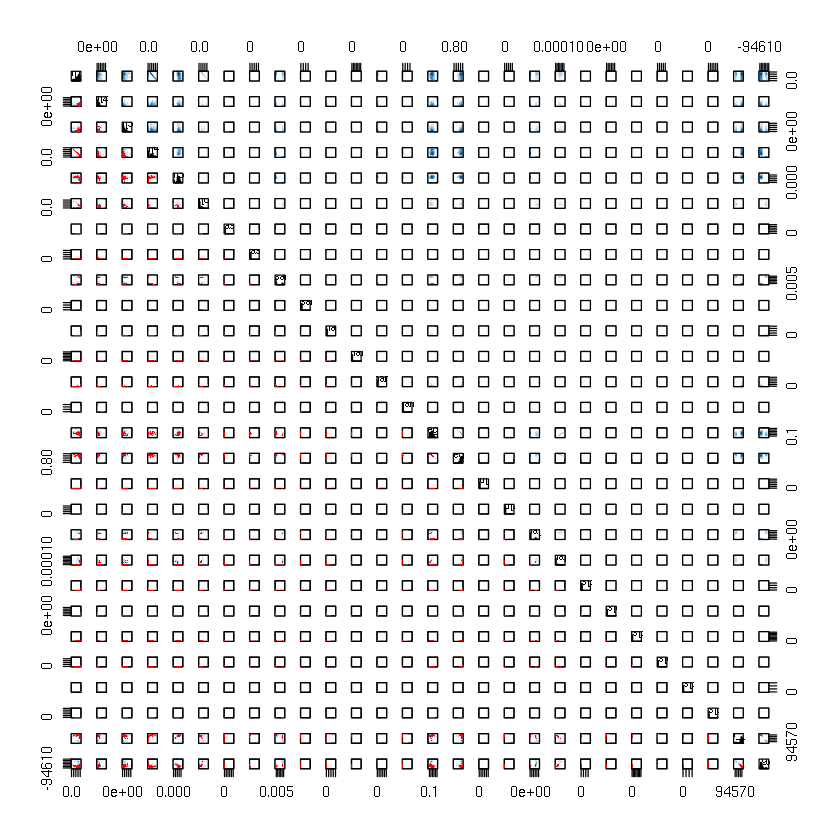

In [27]:
pairs(fit2, pars )

# Looking at M4 output

In [ ]:
require('rstan')


## Single chromosome results

In [8]:
load("../data/biomarker/m4/test_chr/f_m2_Testosterone.RData")
fit2_t <- fit2

load("../data/biomarker/m4/test_chr/f_m2_whr.RData")
fit2_w <- fit2


Doesn't converge!

Warning messages:
1: There were 62 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup 
2: There were 2 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low 
3: Examine the pairs() plot to diagnose sampling problems
 

In [10]:
print(fit2_t, pars=c("sigmass","sigmaf","sigmam","Omegacor","L_Omega","sigmasq", "Sigma", "pi", "lp__"), probs=c(0.1, 0.025, 0.975), digits_summary = 5)

Inference for Stan model: model4_v1.
4 chains, each with iter=600; warmup=200; thin=1; 
post-warmup draws per chain=400, total post-warmup draws=1600.

                     mean se_mean       sd         10%        2.5%       97.5%
sigmass[1]        0.01007 0.00684  0.01048     0.00256     0.00230     0.02918
sigmass[2]        0.01007 0.00684  0.01048     0.00256     0.00230     0.02918
sigmaf[1]         0.22019 0.18329  1.04000     0.00780     0.00637     2.25927
sigmaf[2]         2.30966 2.27615 32.89858     0.03010     0.02834    10.82685
sigmam[1]         1.25096 0.85894  3.06808     0.00367     0.00262     6.86309
sigmam[2]         9.52659 4.03681 34.76944     0.00388     0.00271    69.49244
Omegacor[1,1]     1.00000 0.00000  0.00000     1.00000     1.00000     1.00000
Omegacor[1,2]     0.25050 0.03736  0.08916     0.11742     0.10995     0.42814
Omegacor[2,1]     0.25050 0.03736  0.08916     0.11742     0.10995     0.42814
Omegacor[2,2]     1.00000 0.00000  0.00000     1.00000    

In [11]:
print(fit2_w, pars=c("sigmass","sigmaf","sigmam","Omegacor","L_Omega","sigmasq", "Sigma", "pi", "lp__"), probs=c(0.1, 0.025, 0.975), digits_summary = 5)

Inference for Stan model: model4_v1.
4 chains, each with iter=600; warmup=200; thin=1; 
post-warmup draws per chain=400, total post-warmup draws=1600.

                      mean se_mean        sd          10%         2.5%
sigmass[1]         0.01451 0.01097   0.01563      0.00218      0.00194
sigmass[2]         0.01451 0.01097   0.01563      0.00218      0.00194
sigmaf[1]          1.58377 0.67005   3.30485      0.04344      0.03840
sigmaf[2]         15.03512 3.34251  79.14240      0.04477      0.03983
sigmam[1]          0.01615 0.00571   0.00827      0.00733      0.00708
sigmam[2]          0.02397 0.01075   0.01539      0.00781      0.00751
Omegacor[1,1]      1.00000 0.00000   0.00000      1.00000      1.00000
Omegacor[1,2]      0.77791 0.01054   0.02554      0.74439      0.72664
Omegacor[2,1]      0.77791 0.01054   0.02554      0.74439      0.72664
Omegacor[2,2]      1.00000 0.00000   0.00000      1.00000      1.00000
L_Omega[1,1]       1.00000 0.00000   0.00000      1.00000      1.00

## Removing null SNPs

In [9]:
load("../data/biomarker/m4/f_m2_leg_fp.RData")


Got these warnings:
1: There were 10 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup 
2: Examine the pairs() plot to diagnose sampling problems


In [7]:
print(fit2, pars=c("sigmass","sigmaf","sigmam","Omegacor","L_Omega","sigmasq", "Sigma", "pi", "lp__"), probs=c(0.1, 0.025, 0.975), digits_summary = 5)

Inference for Stan model: model4_v1.
4 chains, each with iter=600; warmup=200; thin=1; 
post-warmup draws per chain=400, total post-warmup draws=1600.

                     mean se_mean        sd         10%        2.5%       97.5%
sigmass[1]        0.01814 0.00000   0.00016     0.01793     0.01782     0.01846
sigmass[2]        0.01814 0.00000   0.00016     0.01793     0.01782     0.01846
sigmaf[1]         1.65628 0.08550   2.70833     0.10178     0.03375     7.50159
sigmaf[2]        18.46427 4.54550 167.90827     0.52935     0.12169    90.30985
sigmam[1]         0.00384 0.00021   0.00229     0.00085     0.00041     0.00736
sigmam[2]         0.02917 0.00012   0.00136     0.02733     0.02684     0.03160
Omegacor[1,1]     1.00000 0.00000   0.00000     1.00000     1.00000     1.00000
Omegacor[1,2]     0.21163 0.00054   0.01496     0.19250     0.18345     0.24153
Omegacor[2,1]     0.21163 0.00054   0.01496     0.19250     0.18345     0.24153
Omegacor[2,2]     1.00000 0.00000   0.00000     

ci_level: 0.8 (80% intervals)
outer_level: 0.95 (95% intervals)


ci_level: 0.8 (80% intervals)
outer_level: 0.95 (95% intervals)


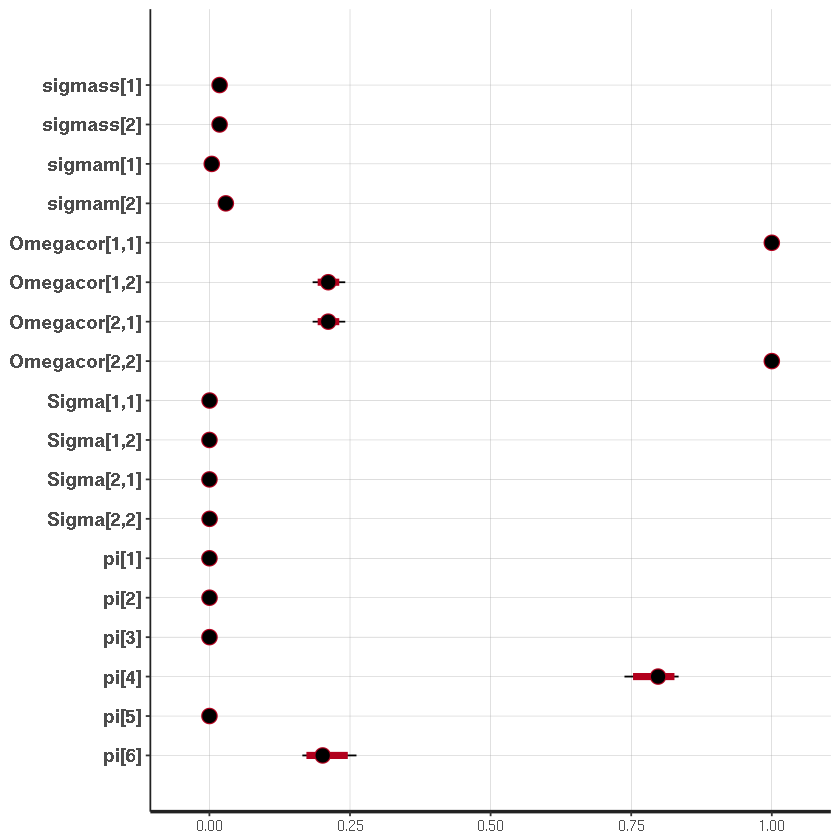

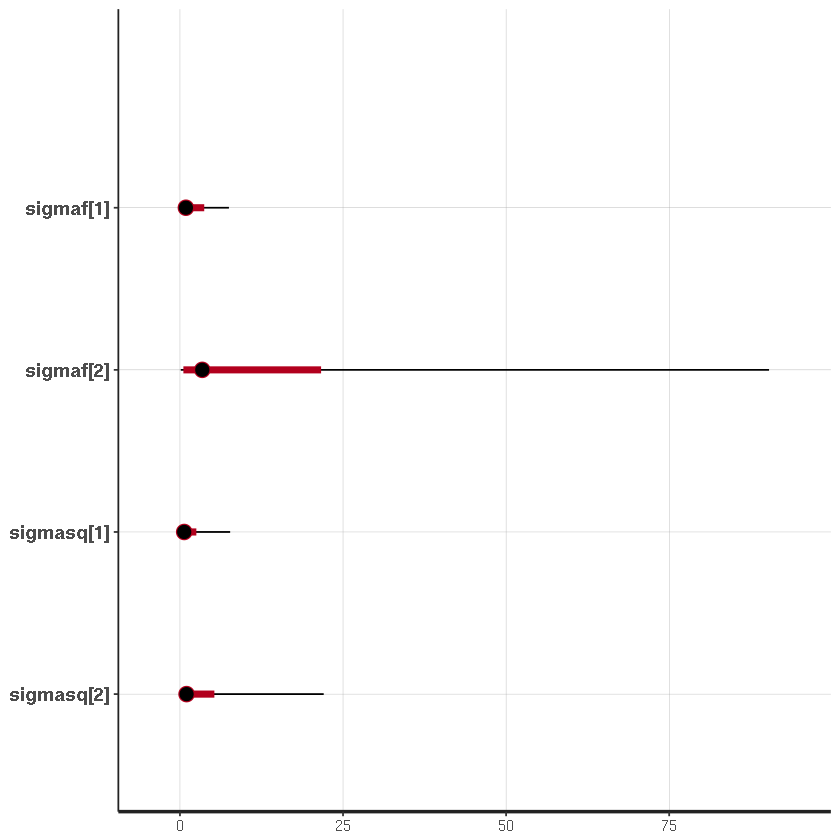

In [16]:
# separated for scales
plot(fit2, pars=c("sigmass","sigmam","Omegacor", "Sigma", "pi"))
plot(fit2, pars=c("sigmaf","sigmasq")) # unclear if converged?

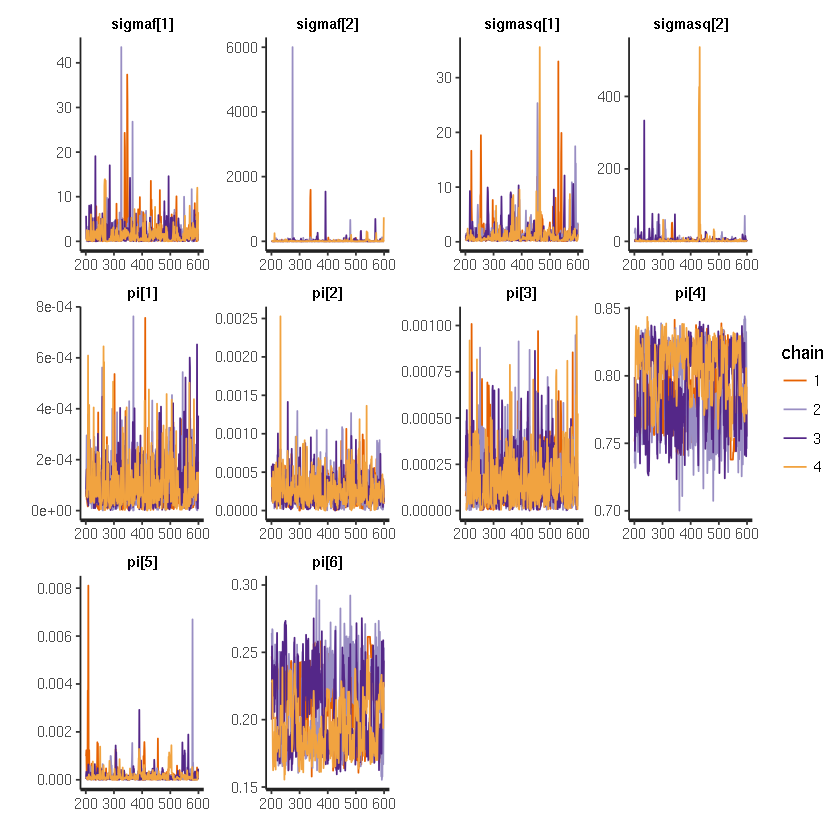

In [18]:
traceplot(fit2, pars=c("sigmaf","sigmasq", "pi"))

In [25]:
sigmas_list <- summary(fit2, pars=c("Sigmas"))$summary[,c("mean")]


getPi <- function(fit){
    fit_summ_pi <- summary(fit, pars=c("pi"), probs=c(0.05, 0.95))
    p <- as.vector(fit_summ_pi$summary[,c("mean")])
    return(p)
}
p <- getPi(fit2)
p

0.000000,0.000000
0.000000,0.000000
1.314958,0.000000
0.000000,0.000000
0.000000,0.000000
0.000000,3.949533


[1] 9.709993e-05 2.549339e-04 1.609040e-04 7.933107e-01 1.574891e-04
[6] 2.060188e-01

In [34]:
 summary(fit2, pars=c("Sigmas"), probs=c(0.05, 0.95))$summary

,mean,se_mean,sd,5%,95%,n_eff,Rhat
"Sigmas[1,1,1]",0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1600.0000,NaN
"Sigmas[1,1,2]",0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1600.0000,NaN
"Sigmas[1,2,1]",0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1600.0000,NaN
"Sigmas[1,2,2]",0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1600.0000,NaN
"Sigmas[2,1,1]",1.314958e+00,9.698179e-02,2.373926e+00,2.029631e-01,4.334084e+00,599.1753,1.0004167
"Sigmas[2,1,2]",0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1600.0000,NaN
"Sigmas[2,2,1]",0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1600.0000,NaN
"Sigmas[2,2,2]",0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1600.0000,NaN
"Sigmas[3,1,1]",0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1600.0000,NaN
"Sigmas[3,1,2]",0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1600.0000,NaN


In [32]:
m = array(1:60, dim=c(3,4,5))
m[1,,]

1,13,25,37,49
4,16,28,40,52
7,19,31,43,55
10,22,34,46,58


In [36]:
Sigmas <- array(sigmas_list, dim=c(6, 2, 2))
Sigmas[1,,] <- matrix(sigmas_list[1:4])
Sigmas[2,,] <- matrix(sigmas_list[5:8])
Sigmas[3,,] <- matrix(sigmas_list[9:12])
Sigmas[4,,] <- matrix(sigmas_list[13:16])
Sigmas[5,,] <- matrix(sigmas_list[17:20])
Sigmas[6,,] <- matrix(sigmas_list[21:24])

Sigmas[1,,]
Sigmas[2,,] 
Sigmas[3,,] 
Sigmas[4,,] 
Sigmas[5,,] 
Sigmas[6,,] 

0,0
0,0


1.314958,0
0.000000,0


0,0.000000
0,3.949533


3.290774e-04,6.964353e-05
6.964353e-05,3.290774e-04


10.07371,24.37925
24.37925,28516.49709


8.525740e-04,2.303394e-05
2.303394e-05,1.999861e-05


In [ ]:
 p_1 = p[1]*dmnorm(B, zeros, SE_mat)
 p_2 = p[2]*dmnorm(B, zeros, SE_mat + Sigmas[2,,])
p_3 = p[3]*dmnorm(B, zeros, SE_mat + Sigmas[3,,])
p_4 = p[4]*dmnorm(B, zeros, SE_mat + Sigmas[4,,])
    p_5 = p[5]*dmnorm(B, zeros, SE_mat + Sigmas[5,,])
    p_6 = p[6]*dmnorm(B, zeros, SE_mat + Sigmas[6,,])

post_vec <- sapply(1:6, function(i){
     p[i]*dmnorm(B, zeros, SE_mat + Sigmas[i,,])
})


In [37]:
load("../data/biomarker/m4/dat_leg_fp.RData")


In [45]:
# ASSIGN TO COMPONENTS
# TODO - double check assignment for M3

require('mnormt')
computePosterior4 <- function(B, SE, p, Sigmas){

    zeros <- c(0,0)
    SE_mat <- matrix(c(SE[1], 0, 0, SE[2]), 2, 2)

    post_vec <- sapply(1:6, function(i){
     p[i]*dmnorm(B, zeros, SE_mat + Sigmas[i,,])
    })
    p_tot <- sum(post_vec)
    prob_vec <- sapply(post_vec, function(x) exp(log(x)-log(p_tot)))
    return(list(unlist(prob_vec)))
}


B.dat <- dat$dat$B
    SE.dat <- dat$dat$SE
    N <- dat$dat$N
    
    posteriors <- lapply(1:N, function(i) computePosterior4(B.dat[i,], SE.dat[i,], p, Sigmas))
    posterior.df <- data.frame(do.call(rbind, posteriors))


In [48]:
require('tidyverse')


Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  1.4.2     ✔ purrr   0.2.4
✔ tidyr   0.8.1     ✔ dplyr   0.7.4
✔ readr   1.1.1     ✔ stringr 1.3.0
✔ tibble  1.4.2     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::extract() masks rstan::extract()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()


do.call.rbind..posteriors.
"3.008399e-05, 1.610631e-06, 4.848015e-05, 9.524762e-01, 4.121722e-09, 4.744365e-02"
"2.364027e-05, 1.442361e-06, 6.401416e-05, 9.584573e-01, 6.203112e-09, 4.145361e-02"
"8.405419e-05, 1.779189e-03, 7.045697e-06, 7.573232e-01, 2.452469e-07, 2.408063e-01"
"1.501402e-05, 4.947818e-07, 2.520263e-05, 9.792526e-01, 1.318323e-09, 2.070669e-02"
"1.271388e-05, 4.216684e-07, 3.496604e-06, 9.499628e-01, 1.840260e-10, 5.002053e-02"
"2.174999e-05, 9.107362e-06, 1.500877e-04, 9.113245e-01, 9.996172e-08, 8.849446e-02"


ERROR: Error in eval_tidy(enquo(var), var_env): object '' not found


In [50]:
head(posterior.df)
colnames(posterior.df) <- c("col")
post2 <- separate(posterior.df, col, c("p1", "p2", "p3", "p4", "p5", "p6"), sep=",")
head(post2)


do.call.rbind..posteriors.
"3.008399e-05, 1.610631e-06, 4.848015e-05, 9.524762e-01, 4.121722e-09, 4.744365e-02"
"2.364027e-05, 1.442361e-06, 6.401416e-05, 9.584573e-01, 6.203112e-09, 4.145361e-02"
"8.405419e-05, 1.779189e-03, 7.045697e-06, 7.573232e-01, 2.452469e-07, 2.408063e-01"
"1.501402e-05, 4.947818e-07, 2.520263e-05, 9.792526e-01, 1.318323e-09, 2.070669e-02"
"1.271388e-05, 4.216684e-07, 3.496604e-06, 9.499628e-01, 1.840260e-10, 5.002053e-02"
"2.174999e-05, 9.107362e-06, 1.500877e-04, 9.113245e-01, 9.996172e-08, 8.849446e-02"


p1,p2,p3,p4,p5,p6
c(3.00839855290893e-05,1.61063149872366e-06,4.84801476683247e-05,0.952476170081863,4.12172170236006e-09,0.0474436510317191)
c(2.36402665849905e-05,1.44236095661339e-06,6.40141580669137e-05,0.958457283408396,6.20311219400505e-09,0.041453613602883)
c(8.40541868308967e-05,0.00177918926555593,7.04569732460267e-06,0.757323210598131,2.45246899412538e-07,0.240806255005258)
c(1.50140237586438e-05,4.94781760191327e-07,2.52026342422092e-05,0.979252597802108,1.31832316261728e-09,0.0207066894398075)
c(1.27138773275649e-05,4.21668444647323e-07,3.49660370574049e-06,0.949962836868926,1.84026010210068e-10,0.0500205307975696)
c(2.17499897838371e-05,9.10736174356136e-06,0.000150087679065584,0.911324498827789,9.99617209023021e-08,0.0884944561798968)


In [52]:
post2$p1 <- sapply(post2$p1, function(x) strsplit(x, "(", fixed=TRUE)[[1]][[2]])
post2$p6 <- sapply(post2$p6, function(x) strsplit(x, ")", fixed=TRUE)[[1]][[1]])

In [ ]:
dat$snp

In [53]:

	# assign to the category with the maximum posterior
	post2$category <- apply(post2, 1, function(x){
		return(which.max(x))
	})


p1,p2,p3,p4,p5,p6,category
3.00839855290893e-05,1.61063149872366e-06,4.84801476683247e-05,0.952476170081863,4.12172170236006e-09,0.0474436510317191,4
2.36402665849905e-05,1.44236095661339e-06,6.40141580669137e-05,0.958457283408396,6.20311219400505e-09,0.041453613602883,4
8.40541868308967e-05,0.00177918926555593,7.04569732460267e-06,0.757323210598131,2.45246899412538e-07,0.240806255005258,4
1.50140237586438e-05,4.94781760191327e-07,2.52026342422092e-05,0.979252597802108,1.31832316261728e-09,0.0207066894398075,4
1.27138773275649e-05,4.21668444647323e-07,3.49660370574049e-06,0.949962836868926,1.84026010210068e-10,0.0500205307975696,4
2.17499897838371e-05,9.10736174356136e-06,0.000150087679065584,0.911324498827789,9.99617209023021e-08,0.0884944561798968,4


In [54]:
	post2$SNP <- dat$snp
	head(post2)

p1,p2,p3,p4,p5,p6,category,SNP
3.00839855290893e-05,1.61063149872366e-06,4.84801476683247e-05,0.952476170081863,4.12172170236006e-09,0.0474436510317191,4,rs116452738
2.36402665849905e-05,1.44236095661339e-06,6.40141580669137e-05,0.958457283408396,6.20311219400505e-09,0.041453613602883,4,rs61770779
8.40541868308967e-05,0.00177918926555593,7.04569732460267e-06,0.757323210598131,2.45246899412538e-07,0.240806255005258,4,rs144586153
1.50140237586438e-05,4.94781760191327e-07,2.52026342422092e-05,0.979252597802108,1.31832316261728e-09,0.0207066894398075,4,rs61766344
1.27138773275649e-05,4.21668444647323e-07,3.49660370574049e-06,0.949962836868926,1.84026010210068e-10,0.0500205307975696,4,rs72631898
2.17499897838371e-05,9.10736174356136e-06,0.000150087679065584,0.911324498827789,9.99617209023021e-08,0.0884944561798968,4,rs140107023


In [55]:
table(post2$category)


    2     4     6 
    1 12222   150 

In [56]:
cat2 <- filter(post2, category==2)
cat2
cat6 <- filter(post2, category==6)
head(cat6)

p1,p2,p3,p4,p5,p6,category,SNP
1.16140133174065e-06,0.899186439580379,5.29194045826529e-08,0.037521669347865,6.7220988847598e-05,0.0632234557621718,2,rs150090666


p1,p2,p3,p4,p5,p6,category,SNP
5.51499401380145e-06,0.000245613464255367,1.33302315014852e-07,0.484168934104261,9.44388219894551e-09,0.515579794691273,6,rs145659444
2.97897397143143e-14,5.6004290480073e-05,9.84816328400716e-16,0.440576459499518,2.94082424531383e-09,0.559367533269147,6,rs115584674
6.47894441875989e-10,0.000109610316247921,1.11107264878453e-11,0.36460366972855,2.98623085501223e-09,0.635286716309966,6,rs56228576
4.75149345664106e-09,0.000449249896309436,7.93465994789226e-11,0.209958141793168,1.1929196469158e-08,0.789592591550486,6,rs11580946
1.12523436826333e-06,5.33544631720985e-05,1.12583037792022e-08,0.491251419238024,8.476841641657e-10,0.508694088958448,6,rs7531602
5.58008135459827e-08,5.05133490043683e-05,4.22425242571161e-10,0.459732416666022,6.07133941860179e-10,0.5402170131546,6,rs116811962


In [57]:
source('../mixture_model_scripts/model_utils.R')
list.prefixes <- c("zerosex", "onesex")
trait <- "leg_fp"
chrs <- c(1:22)
        list.ds <- lapply(list.prefixes, function(prefix) {
                all.dat <- do.call(rbind, lapply(chrs, function(chr) { getFile(prefix, chr, trait)}));
                colnames(all.dat)[1:3] <- c("CHR", "BP", "SNP");
                return(all.dat)
            })

        list.ds2 <- extractOverlappingRows(list.ds)
	df.f <- list.ds2[[1]]
	df.m <- list.ds2[[2]]


Loading required package: MASS

Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select

Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand

Loading required package: qqman

For example usage please run: vignette('qqman')

Citation appreciated but not required:
Turner, S.D. qqman: an R package for visualizing GWAS results using Q-Q and manhattan plots. biorXiv DOI: 10.1101/005165 (2014).



[1] "File missing for c1 trait:leg_fp zerosex"
[1] "File missing for c2 trait:leg_fp zerosex"
[1] "File missing for c3 trait:leg_fp zerosex"
[1] "File missing for c4 trait:leg_fp zerosex"
[1] "File missing for c5 trait:leg_fp zerosex"
[1] "File missing for c6 trait:leg_fp zerosex"
[1] "File missing for c7 trait:leg_fp zerosex"
[1] "File missing for c8 trait:leg_fp zerosex"
[1] "File missing for c9 trait:leg_fp zerosex"
[1] "File missing for c10 trait:leg_fp zerosex"
[1] "File missing for c11 trait:leg_fp zerosex"
[1] "File missing for c12 trait:leg_fp zerosex"
[1] "File missing for c13 trait:leg_fp zerosex"
[1] "File missing for c14 trait:leg_fp zerosex"
[1] "File missing for c15 trait:leg_fp zerosex"
[1] "File missing for c16 trait:leg_fp zerosex"
[1] "File missing for c17 trait:leg_fp zerosex"
[1] "File missing for c18 trait:leg_fp zerosex"
[1] "File missing for c19 trait:leg_fp zerosex"
[1] "File missing for c20 trait:leg_fp zerosex"
[1] "File missing for c21 trait:leg_fp zerosex"
[

In [65]:
extractSNPcat4 <- function(snp.df, df.f, df.m, category){
    comp4 <- snp.df[which(snp.df$category==category),c("p1", "p2", "p3", "p4","p5", "p6", "SNP")]
    if (length(comp4$SNP) > 0){
            both.snps <- cbind(df.f[df.f$SNP %in% comp4$SNP ,c("SNP", "CHR", "BP", "BETA","SE", "P")], 
             df.m[df.m$SNP %in% comp4$SNP,c("BETA","SE", "P")])
            colnames(both.snps) <- c("SNP", "CHR", "BP", "B_f", "SE_f", "p_f", "B_m", "SE_m", "p_m")
            both.snp.df <- both.snps[,c("SNP", "CHR", "BP", "B_f", "B_m", "SE_f", "SE_m", "p_m","p_f")] 
            both.snp.df <- merge(both.snp.df, comp4, by="SNP")       
    both.snp.df2 <- annotateSNP(both.snp.df)

    return(both.snp.df2)
        }
}

In [62]:
source("../mixture_model_scripts/snp_utils.R")

In [66]:
snp.df <- post2	
cat6a <- extractSNPcat4(snp.df, df.f, df.m, 6) 
cat2a <- extractSNPcat4(snp.df, df.f, df.m, 2) 


In [77]:
cat6a <- cat6a %>% arrange(desc(p6) )

write.table(cat6a, file="../data/biomarker/m4/leg_fp_cat6.txt", row.names=FALSE, sep="\t")
write.table(cat2a, file="../data/biomarker/m4/leg_fp_cat2.txt", row.names=FALSE, sep="\t")

In [80]:
cat2a[,c("SNP", "B_f", "B_m", "SE_f", "SE_m", "p_m","p_f", "p2", "gene")]
cat6a[,c("SNP", "B_f", "B_m", "SE_f", "SE_m", "p_m","p_f", "p6", "gene")]

SNP,B_f,B_m,SE_f,SE_m,p_m,p_f,p2,gene
rs150090666,-0.311644,0.00941819,0.0556912,0.0538364,0.861126,2.19826e-08,0.899186439580379,PDE3B


SNP,B_f,B_m,SE_f,SE_m,p_m,p_f,p6,gene
rs16942341,0.0983448,-0.017593700,0.01077520,0.01062910,0.0978798,7.12832e-20,0.982941125128308,ACAN
rs41271299,-0.0749335,0.003918240,0.00819688,0.00809078,0.6281850,6.21896e-20,0.960038945390768,ID4
rs77146408,-0.0899494,-0.000289245,0.01291700,0.01265020,0.9817580,3.32893e-12,0.956014041200016,GRM4
rs75223147,-0.0795803,0.001314920,0.01262450,0.01240870,0.9156080,2.91546e-10,0.90685460817679,NA
rs117187575,-0.0709304,0.007317750,0.01043430,0.01044870,0.4837110,1.06599e-11,0.888027385903294,PIGU
rs11729800,-0.0648217,-0.009168650,0.00740094,0.00737102,0.2135470,1.99677e-18,0.859442765723191,ADAMTS3
rs9358913,0.0521167,0.001893280,0.00412513,0.00410202,0.6444060,1.43119e-36,0.854144897528468,HIST1H1D
rs1326122,-0.0736036,-0.003174450,0.01256170,0.01244270,0.7986270,4.65636e-09,0.84777264261698,DLEU1
rs12795957,0.0605303,0.005007580,0.00777633,0.00778317,0.5199750,7.07522e-15,0.840962411955843,AIP
rs149615348,0.1080910,0.004790720,0.02146700,0.02164460,0.8248310,4.77790e-07,0.828669762675728,CRISPLD2
